In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For better aesthetics if desired

In [2]:
csv_file_path = '../data/processed/combined_processed.csv'

print(f"Loading historical data from {csv_file_path}...")
try:
    # Load data from the CSV file
    # Ensure 'Date' column is parsed as datetime
    raw_data = pd.read_csv(csv_file_path, parse_dates=['Date'])
    
    # --- IMPORTANT ADJUSTMENT FOR 'Ticker' COLUMN ---
    # We need to pivot the data so each 'Ticker' becomes a column
    # with its 'Adj Close' price as the values.
    # Check if 'Ticker' and 'Adj Close' columns exist
    if 'Ticker' not in raw_data.columns or 'Adj Close' not in raw_data.columns:
        raise ValueError("CSV must contain 'Date', 'Ticker', and 'Adj Close' columns.")
    
    # Set 'Date' as index first if not already, then pivot
    # Using 'Date' as index for time series operations
    raw_data.set_index('Date', inplace=True)
    
    # Pivot the table to get tickers as columns and Adj Close prices as values
    # The columns in adj_close_prices will now be 'BND', 'SPY', 'TSLA' (or whatever tickers are in the data)
    adj_close_prices = raw_data.pivot_table(index='Date', columns='Ticker', values='Adj Close')
    
    # Dynamically get the list of tickers that were actually loaded and are now columns
    tickers = adj_close_prices.columns.tolist()

    # --- Robustness Check: Ensure we have data for at least two tickers ---
    if adj_close_prices.empty or len(tickers) < 2:
        raise ValueError("Insufficient historical data loaded from CSV. Requires at least two unique tickers with 'Adj Close' data.")
    
    print("Historical data loaded successfully from CSV.")
    print(f"Loaded data for tickers: {tickers}")

except FileNotFoundError:
    print(f"Error: The file '{csv_file_path}' was not found. Please ensure it's in the correct directory.")
    exit()
except Exception as e:
    print(f"Error loading data from CSV: {e}")
    print("Please check the CSV file format and column names ('Date', 'Ticker', 'Adj Close'). Exiting.")
    exit()

Loading historical data from ../data/processed/combined_processed.csv...
Historical data loaded successfully from CSV.
Loaded data for tickers: ['BND', 'SPY', 'TSLA']


In [3]:
# Calculate daily returns for all assets
# This will now operate on the correctly pivoted DataFrame
daily_returns = adj_close_prices.pct_change().dropna()

# --- NEW ROBUSTNESS CHECK AND DYNAMIC TICKER LIST ---
# After pct_change().dropna(), update the `active_tickers` list to reflect what actually survived.
# This ensures that `active_tickers` matches the columns of `daily_returns`
active_tickers = daily_returns.columns.tolist()

if len(active_tickers) < 2:
    raise ValueError(
        f"Cannot compute covariance matrix: Only {len(active_tickers)} valid ticker(s) with daily returns found after processing. "
        f"Requires at least two. Please ensure at least two unique tickers have valid historical data for the specified date range."
    )
# --- END NEW ROBUSTNESS CHECK ---

print("\nFirst 5 rows of daily returns for all assets:")
print(daily_returns.head())


First 5 rows of daily returns for all assets:
Ticker           BND       SPY      TSLA
Date                                    
2015-06-02 -0.002808 -0.000993 -0.004410
2015-06-03 -0.004407  0.002649  0.002577
2015-06-04  0.002460 -0.008446 -0.012330
2015-06-05 -0.003926 -0.001713  0.013094
2015-06-08  0.001232 -0.006149  0.028699


/tmp/ipykernel_803511/2852184706.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = adj_close_prices.pct_change().dropna()


In [4]:
trading_days_per_year = 252 # Standard number of trading days in a year
risk_free_rate = 0.03 # Assuming a 3% annual risk-free rate for Sharpe Ratio calculation

# Calculate historical average daily returns for each asset
# This will now operate on the `daily_returns` DataFrame which only contains `active_tickers`
expected_daily_returns = daily_returns.mean()

# Annualize the expected daily returns
expected_annual_returns = expected_daily_returns * trading_days_per_year
print("\nExpected Annual Returns (based on historical averages):")
print(expected_annual_returns)



Expected Annual Returns (based on historical averages):
Ticker
BND     0.018724
SPY     0.126933
TSLA    0.457707
dtype: float64


In [5]:
expected_returns_vector = expected_annual_returns.values

# --- 3. Compute Covariance Matrix ---
# The covariance matrix shows how the returns of different assets move together.
# This is crucial for calculating portfolio risk.
# This call should now work correctly as daily_returns is ensured to be a DataFrame.
covariance_matrix_daily = daily_returns.cov()

# Annualize the covariance matrix
# Covariance is scaled by the number of trading days
covariance_matrix_annual = covariance_matrix_daily * trading_days_per_year
print("\nAnnualized Covariance Matrix:")
print(covariance_matrix_annual)


Annualized Covariance Matrix:
Ticker       BND       SPY      TSLA
Ticker                              
BND     0.002683  0.000303  0.000836
SPY     0.000303  0.028875  0.028642
TSLA    0.000836  0.028642  0.335930


In [7]:
num_portfolios = 10000 # Number of random portfolios to simulate

# Initialize lists to store portfolio metrics
portfolio_returns = []
portfolio_volatility = []
portfolio_weights = []
portfolio_sharpe_ratios = []

# Loop to generate random portfolios
for _ in range(num_portfolios):
    # Generate random weights for each asset.
    # The number of weights now correctly matches the number of `active_tickers`.
    weights = np.random.random(len(active_tickers))
    weights /= np.sum(weights) # Normalize weights so they sum to 1

    # Calculate portfolio expected return
    # `weights` and `expected_returns_vector` will now have matching dimensions.
    p_return = np.dot(weights, expected_returns_vector)

    # Calculate portfolio volatility (risk)
    # Formula: sqrt(w' * Cov * w) where w' is transpose of weights
    p_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix_annual, weights)))

    # Calculate Sharpe Ratio
    sharpe_ratio = (p_return - risk_free_rate) / p_volatility

    # Store results
    portfolio_returns.append(p_return)
    portfolio_volatility.append(p_volatility)
    portfolio_weights.append(weights)
    portfolio_sharpe_ratios.append(sharpe_ratio)

# Convert lists to NumPy arrays for easier manipulation
portfolio_returns = np.array(portfolio_returns)
portfolio_volatility = np.array(portfolio_volatility)
portfolio_sharpe_ratios = np.array(portfolio_sharpe_ratios)
portfolio_weights = np.array(portfolio_weights)

In [8]:
max_sharpe_idx = np.argmax(portfolio_sharpe_ratios)
max_sharpe_return = portfolio_returns[max_sharpe_idx]
max_sharpe_volatility = portfolio_volatility[max_sharpe_idx]
max_sharpe_weights = portfolio_weights[max_sharpe_idx]
max_sharpe_ratio = portfolio_sharpe_ratios[max_sharpe_idx]

In [10]:
min_vol_idx = np.argmin(portfolio_volatility)
min_vol_return = portfolio_returns[min_vol_idx]
min_vol_volatility = portfolio_volatility[min_vol_idx]
min_vol_weights = portfolio_weights[min_vol_idx]
min_vol_sharpe_ratio = portfolio_sharpe_ratios[min_vol_idx]

In [11]:
print("\n--- Maximum Sharpe Ratio Portfolio (Tangency Portfolio) ---")
print(f"Expected Annual Return: {max_sharpe_return:.4f}")
print(f"Annual Volatility: {max_sharpe_volatility:.4f}")
print(f"Sharpe Ratio: {max_sharpe_ratio:.4f}")
print("Weights:")
for i, ticker_name in enumerate(active_tickers): # Use active_tickers here
    print(f"  {ticker_name}: {max_sharpe_weights[i]:.4f}")

print("\n--- Minimum Volatility Portfolio ---")
print(f"Expected Annual Return: {min_vol_return:.4f}")
print(f"Annual Volatility: {min_vol_volatility:.4f}")
print(f"Sharpe Ratio: {min_vol_sharpe_ratio:.4f}")
print("Weights:")
for i, ticker_name in enumerate(active_tickers): # Use active_tickers here
    print(f"  {ticker_name}: {min_vol_weights[i]:.4f}")


--- Maximum Sharpe Ratio Portfolio (Tangency Portfolio) ---
Expected Annual Return: 0.2287
Annual Volatility: 0.2405
Sharpe Ratio: 0.8261
Weights:
  BND: 0.0036
  SPY: 0.6876
  TSLA: 0.3088

--- Minimum Volatility Portfolio ---
Expected Annual Return: 0.0303
Annual Volatility: 0.0503
Sharpe Ratio: 0.0052
Weights:
  BND: 0.8942
  SPY: 0.1055
  TSLA: 0.0003


In [62]:
covariance_matrix_daily = []
for ticker in tickers:
    covariance_matrix_daily.append(stock_data_raw.loc[stock_data_raw['Ticker']==ticker]['daily_percentage'].to_frame().cov().values[0])
covariance_matrix_daily = pd.DataFrame(covariance_matrix_daily)
covariance_matrix_daily = covariance_matrix_daily.values.T


In [29]:
num_portfolios = 10000 
covariance_matrix_annual = covariance_matrix_daily * trading_days_per_year
print("\nAnnualized Covariance Matrix:")
covariance_matrix_annual = pd.DataFrame(covariance_matrix_annual)
covariance_matrix_annual = covariance_matrix_annual.values


Annualized Covariance Matrix:


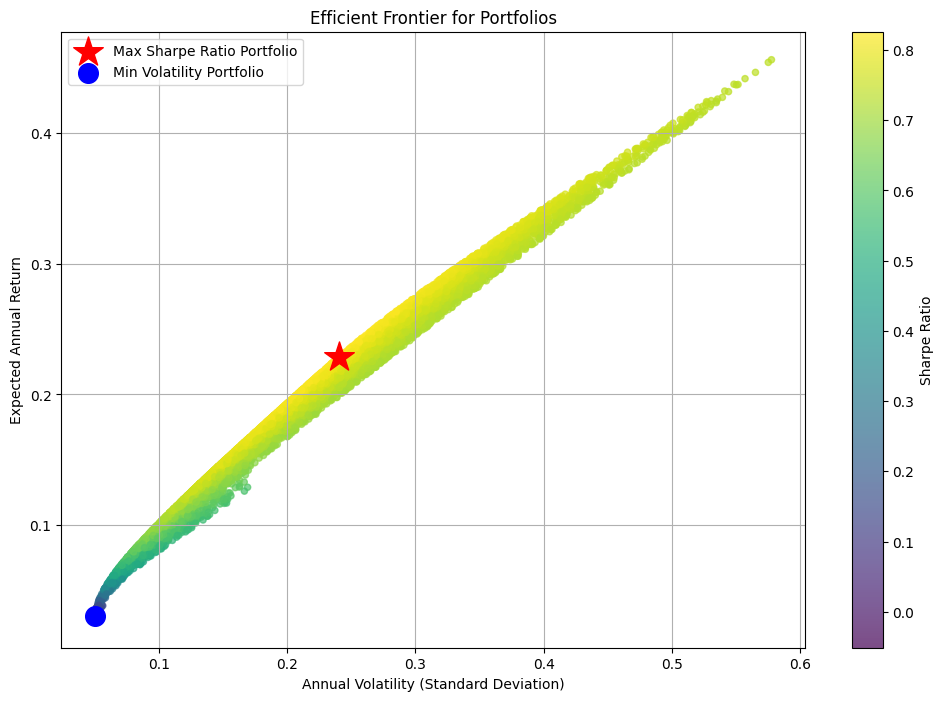

In [12]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(portfolio_volatility, portfolio_returns, c=portfolio_sharpe_ratios, cmap='viridis', s=20, alpha=0.7)
plt.colorbar(scatter, label='Sharpe Ratio')
plt.title('Efficient Frontier for Portfolios')
plt.xlabel('Annual Volatility (Standard Deviation)')
plt.ylabel('Expected Annual Return')
plt.grid(True)

# Mark the Maximum Sharpe Ratio Portfolio
plt.scatter(max_sharpe_volatility, max_sharpe_return, marker='*', color='red', s=500, label='Max Sharpe Ratio Portfolio')
# Mark the Minimum Volatility Portfolio
plt.scatter(min_vol_volatility, min_vol_return, marker='o', color='blue', s=200, label='Min Volatility Portfolio')

plt.legend()
plt.show()

In [19]:
print("\n--- Final Recommended Portfolio Summary ---")
# Recommendation based on an example preference (e.g., maximizing risk-adjusted return)
recommended_portfolio_name = "Maximum Sharpe Ratio Portfolio" # Or "Minimum Volatility Portfolio" based on preference

if recommended_portfolio_name == "Maximum Sharpe Ratio Portfolio":
    final_weights_strategy = max_sharpe_weights
    final_return_strategy = max_sharpe_return
    final_volatility_strategy = max_sharpe_volatility
    final_sharpe_strategy = max_sharpe_ratio
    justification = "This portfolio offers the highest expected return per unit of risk, making it ideal for investors seeking to maximize their risk-adjusted returns."
else:
    final_weights_strategy = min_vol_weights
    final_return_strategy = min_vol_return
    final_volatility_strategy = min_vol_volatility
    final_sharpe_strategy = min_vol_sharpe_ratio
    justification = "This portfolio aims to minimize the overall risk (volatility) for a given level of return, suitable for risk-averse investors."

print(f"Recommended Portfolio: {recommended_portfolio_name}")
print(f"Justification: {justification}")
print("\nOptimal Weights:")
for i, ticker_name in enumerate(active_tickers):
    print(f"  {ticker_name}: {final_weights_strategy[i]:.4f}")
print(f"\nExpected Annual Return: {final_return_strategy:.4f}")
print(f"Annual Volatility: {final_volatility_strategy:.4f}")
print(f"Sharpe Ratio: {final_sharpe_strategy:.4f}")


--- Final Recommended Portfolio Summary ---
Recommended Portfolio: Maximum Sharpe Ratio Portfolio
Justification: This portfolio offers the highest expected return per unit of risk, making it ideal for investors seeking to maximize their risk-adjusted returns.

Optimal Weights:
  BND: 0.0036
  SPY: 0.6876
  TSLA: 0.3088

Expected Annual Return: 0.2287
Annual Volatility: 0.2405
Sharpe Ratio: 0.8261


In [14]:
print("\n" + "="*50)
print("--- Starting Backtesting Simulation ---")
print("="*50)

# Define a Backtesting Period (last year of the dataset)
# Get the last date from the loaded data
last_date_in_data = daily_returns.index.max()
# Calculate the start date for 1 year prior (approx. 252 business days)
backtest_start_date = last_date_in_data - pd.DateOffset(years=1)

# Filter data for the backtesting period
backtest_daily_returns = daily_returns.loc[backtest_start_date:last_date_in_data].copy()


--- Starting Backtesting Simulation ---


In [15]:
if backtest_daily_returns.empty:
    raise ValueError(f"No data available for the backtesting period: {backtest_start_date} to {last_date_in_data}. "
                     f"Please check your dataset's date range.")

print(f"\nBacktesting Period: {backtest_daily_returns.index.min().strftime('%Y-%m-%d')} to {backtest_daily_returns.index.max().strftime('%Y-%m-%d')}")
print(f"Number of trading days in backtest: {len(backtest_daily_returns)}")


Backtesting Period: 2024-07-01 to 2025-06-30
Number of trading days in backtest: 250


In [16]:
benchmark_weights = {'SPY': 0.60, 'BND': 0.40}

# --- Robustness Check for Benchmark assets 
# Ensure SPY and BND are in the active_tickers list for benchmark calculation
if 'SPY' not in active_tickers or 'BND' not in active_tickers:
    raise ValueError(f"Cannot create benchmark: 'SPY' and/or 'BND' are not present in active_tickers ({active_tickers}). "
                     f"Ensure your combined_processed.csv contains data for SPY and BND.")

benchmark_daily_returns_calc = backtest_daily_returns[['SPY', 'BND']] @ np.array([benchmark_weights['SPY'], benchmark_weights['BND']])

In [17]:
benchmark_cumulative_returns = (1 + benchmark_daily_returns_calc).cumprod() - 1
benchmark_total_return = benchmark_cumulative_returns.iloc[-1]

# Calculate benchmark's annualized return and volatility for Sharpe Ratio
benchmark_annual_return = benchmark_daily_returns_calc.mean() * trading_days_per_year
benchmark_annual_volatility = benchmark_daily_returns_calc.std() * np.sqrt(trading_days_per_year)
benchmark_sharpe_ratio = (benchmark_annual_return - risk_free_rate) / benchmark_annual_volatility

print("\n--- Benchmark Portfolio (60% SPY / 40% BND) ---")
print(f"Benchmark Total Return: {benchmark_total_return:.4f}")
print(f"Benchmark Annual Volatility: {benchmark_annual_volatility:.4f}")
print(f"Benchmark Sharpe Ratio: {benchmark_sharpe_ratio:.4f}")


--- Benchmark Portfolio (60% SPY / 40% BND) ---
Benchmark Total Return: 0.0338
Benchmark Annual Volatility: 0.0577
Benchmark Sharpe Ratio: 0.0901


In [21]:
strategy_weights = final_weights_strategy

# Ensure strategy_weights align with backtest_daily_returns columns
# Create a dictionary mapping ticker names to their weights for easy lookup
strategy_weights_dict = {active_tickers[i]: strategy_weights[i] for i in range(len(active_tickers))}

# Select columns from backtest_daily_returns that match active_tickers and apply weights
# This handles cases where original tickers list might differ from active_tickers
strategy_daily_returns_calc = backtest_daily_returns[active_tickers].copy() @ np.array([strategy_weights_dict[t] for t in active_tickers])


# Calculate cumulative returns for the strategy
strategy_cumulative_returns = (1 + strategy_daily_returns_calc).cumprod() - 1
strategy_total_return = strategy_cumulative_returns.iloc[-1]

# Calculate strategy's annualized return and volatility for Sharpe Ratio
strategy_annual_return = strategy_daily_returns_calc.mean() * trading_days_per_year
strategy_annual_volatility = strategy_daily_returns_calc.std() * np.sqrt(trading_days_per_year)
strategy_sharpe_ratio = (strategy_annual_return - risk_free_rate) / strategy_annual_volatility
print("\n--- Strategy Portfolio (Initial Optimal Weights) ---")
print(f"Strategy Total Return: {strategy_total_return:.4f}")
print(f"Strategy Annual Volatility: {strategy_annual_volatility:.4f}")
print(f"Strategy Sharpe Ratio: {strategy_sharpe_ratio:.4f}")


--- Strategy Portfolio (Initial Optimal Weights) ---
Strategy Total Return: 0.2317
Strategy Annual Volatility: 0.2530
Strategy Sharpe Ratio: 0.8375


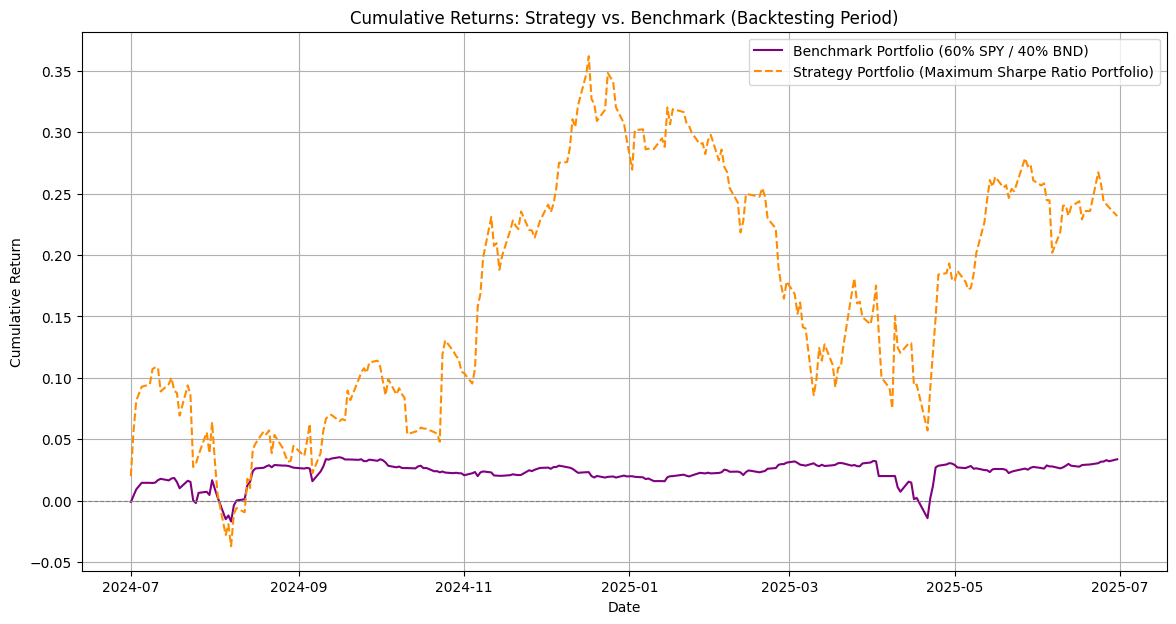

In [22]:
plt.figure(figsize=(14, 7))
plt.plot(benchmark_cumulative_returns.index, benchmark_cumulative_returns, label='Benchmark Portfolio (60% SPY / 40% BND)', color='purple')
plt.plot(strategy_cumulative_returns.index, strategy_cumulative_returns, label=f'Strategy Portfolio ({recommended_portfolio_name})', color='darkorange', linestyle='--')
plt.title('Cumulative Returns: Strategy vs. Benchmark (Backtesting Period)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8) # Add a zero line
plt.show()

In [23]:
print("\n" + "="*50)
print("--- Backtesting Summary ---")
print("="*50)

print(f"\nFinal Total Returns:")
print(f"  Strategy Portfolio: {strategy_total_return:.4f}")
print(f"  Benchmark Portfolio: {benchmark_total_return:.4f}")

print(f"\nAnnualized Sharpe Ratios:")
print(f"  Strategy Portfolio: {strategy_sharpe_ratio:.4f}")
print(f"  Benchmark Portfolio: {benchmark_sharpe_ratio:.4f}")


--- Backtesting Summary ---

Final Total Returns:
  Strategy Portfolio: 0.2317
  Benchmark Portfolio: 0.0338

Annualized Sharpe Ratios:
  Strategy Portfolio: 0.8375
  Benchmark Portfolio: 0.0901


In [26]:
if strategy_sharpe_ratio > benchmark_sharpe_ratio:
    performance_summary = "Your strategy portfolio **outperformed** the benchmark in terms of risk-adjusted returns (Sharpe Ratio)."
elif strategy_sharpe_ratio < benchmark_sharpe_ratio:
    performance_summary = "Your strategy portfolio **underperformed** the benchmark in terms of risk-adjusted returns (Sharpe Ratio)."
else:
    performance_summary = "Your strategy portfolio performed **similarly** to the benchmark in terms of risk-adjusted returns."

if strategy_total_return > benchmark_total_return:
    return_summary = "It also achieved a **higher total return** over the backtesting period."
elif strategy_total_return < benchmark_total_return:
    return_summary = "However, it achieved a **lower total return** over the backtesting period."
else:
    return_summary = "It achieved a **similar total return** over the backtesting period."

print(f"\nBacktest Suggestion: {performance_summary} {return_summary}")



Backtest Suggestion: Your strategy portfolio **outperformed** the benchmark in terms of risk-adjusted returns (Sharpe Ratio). It also achieved a **higher total return** over the backtesting period.
